In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from importlib import reload
import mathutils
import fitsio
import setcover
import scipy.optimize as op
import cosmology as cosmo
import datapath
import ebossspec
import archespec
from scipy.ndimage import gaussian_filter1d
from matplotlib.colors import LogNorm

In [2]:
plt.rcParams["figure.figsize"]=(10,8)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.major.size'] = 15
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['ytick.labelsize'] = 25

In [3]:
def color_legend_texts(leg):
    """Color legend texts based on color of corresponding lines"""
    for line, txt in zip(leg.get_lines(), leg.get_texts()):
        txt.set_color(line.get_color())  

In [4]:
elg_composite = fitsio.read('../ELG_composite.fits', ext=1)
feii_composite = fitsio.read('../FeII_MgII_Composite.fits', ext=1)

In [5]:
nfl_sdss = fitsio.read('/Users/Benjamin/AstroData/Garching/hstnfl_sample.fits', ext=1)

In [90]:
index_of_index = np.array([0,5,4,1])
nfl_composite = np.mean(nfl_sdss['ALLFLUX'][0], axis=1)
print(nfl_composite.shape)

(13659,)


In [7]:
masterwave, allflux, allivar = ebossspec.rest_allspec_readin()
objs_ori = ebossspec.elg_readin()
nobj = objs_ori.size
galaxytype = objs_ori['CLASS']
zgood = objs_ori['zGOOD']
z = objs_ori['Z']

Reading /Users/Benjamin/AstroData/AllInOne/AIO_ELG_eBOSS_SDSSRestFrame_Wave01800_03600A.fits.
Reading /Users/Benjamin/AstroData/AllInOne/AIO_ELG_eBOSS_SDSSRestFrame_Wave03600_07200A.fits.
Reading /Users/Benjamin/AstroData/AllInOne/AIO_ELG_eBOSS_SDSSRestFrame_Wave07200_10400A.fits.


In [8]:
index_wave_all = np.searchsorted(masterwave, [2000., 5199.])
tmpflux = allflux[index_wave_all[0]:index_wave_all[1],:]
tmpivar = allivar[index_wave_all[0]:index_wave_all[1],:]
tmpwave = masterwave[index_wave_all[0]:index_wave_all[1]]
tmploglam = np.log10(tmpwave)

In [9]:
median_sn = np.zeros(objs_ori.size)
for i in np.arange(objs_ori.size):
    iuse = (np.where(tmpivar[:,i]>0))[0]
    if iuse.size>0:
        median_sn[i] = np.median(tmpflux[iuse,i]*np.sqrt(tmpivar[iuse,i]))

In [6]:
# Calculate oii_ew and oii_luminosity
# 1Mpc = 3.08568025x10^24 cm
Mpc_cm = 3.08568025E24
oiilum = np.zeros(nobj)
oii_ew = np.zeros(nobj)
index_oii = np.searchsorted(tmpwave, 3728.48)
dnoiiwave = 10
dwave = np.median(tmpwave[index_oii-dnoiiwave:index_oii+dnoiiwave]-tmpwave[index_oii-dnoiiwave-1:index_oii+dnoiiwave-1])
print(dwave, tmpwave[index_oii-dnoiiwave], tmpwave[index_oii+dnoiiwave])
oiisum = np.sum(tmpflux[index_oii-dnoiiwave:index_oii+dnoiiwave, :]*
             (tmpivar[index_oii-dnoiiwave:index_oii+dnoiiwave, :]>0), axis=0)*dwave # Need to subtract the negligible continuum
oii_left = np.sum(tmpflux[index_oii-25:index_oii-15, :]*(tmpivar[index_oii-25:index_oii-15, :]>0), axis=0)/(25.-15.)
oii_right = np.sum(tmpflux[index_oii+15:index_oii+25, :]*(tmpivar[index_oii+15:index_oii+25, :]>0), axis=0)/(25.-15.)
oii_cont = (oii_left+oii_right)/2.
oii_ew = (oiisum-oii_cont*dwave)/oii_cont
oiilum = (oiisum-oii_cont*dwave)*np.power(cosmo.luminosity_distance(z), 2)*4.*np.pi*np.power(Mpc_cm,2)*1E-17


# Calculate feii_ew and feii_luminosity
feiilum = np.zeros(nobj)
feii_ew = np.zeros(nobj)
index_feii = np.searchsorted(tmpwave, 2626.)
dnfeiiwave = 7
dwave = np.median(tmpwave[index_feii-dnfeiiwave:index_feii+dnfeiiwave]-tmpwave[index_feii-dnfeiiwave-1:index_feii+dnfeiiwave-1])
print(dwave, tmpwave[index_feii-dnfeiiwave], tmpwave[index_feii+dnfeiiwave])
feiisum = np.sum(tmpflux[index_feii-dnfeiiwave:index_feii+dnfeiiwave, :]*
             (tmpivar[index_feii-dnfeiiwave:index_feii+dnfeiiwave, :]>0), axis=0)*dwave # Need to subtract the negligible continuum
feii_left = np.sum(tmpflux[index_feii-15:index_feii-8, :]*(tmpivar[index_feii-15:index_feii-8, :]>0), axis=0)/(15-8.)
feii_right = np.sum(tmpflux[index_feii+8:index_feii+15, :]*(tmpivar[index_feii+8:index_feii+15, :]>0), axis=0)/(15.-8)
feii_cont = (feii_left+feii_right)/2.
feii_ew = (feiisum-feii_cont)/feii_cont
feiilum = (feiisum-feii_cont*dwave)*np.power(cosmo.luminosity_distance(z), 2)*4.*np.pi*np.power(Mpc_cm,2)*1E-17

0.858337689539 3719.99614856 3737.16687061
0.604586134328 2622.0591844 2630.52534306


In [7]:
inuv = (np.where(np.logical_and(np.logical_and(\
                np.logical_and(np.logical_and(zgood==1, galaxytype==b'GALAXY'), median_sn>0.),\
                                               z<0.4798), z>0.4702)))[0]
print(inuv.shape)

(87,)


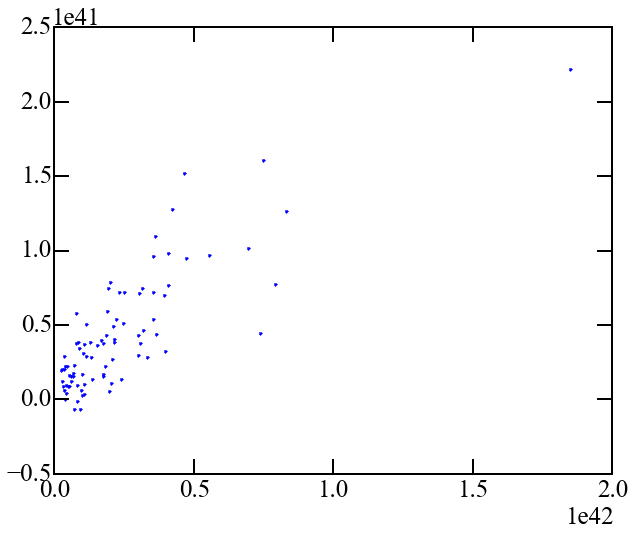

In [8]:
plt.plot(oiilum[inuv], feiilum[inuv], '.')
#plt.xlim(0,100)
#plt.ylim(0,20)

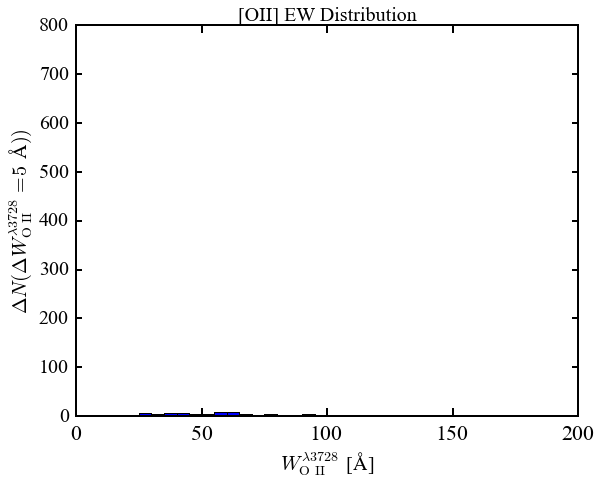

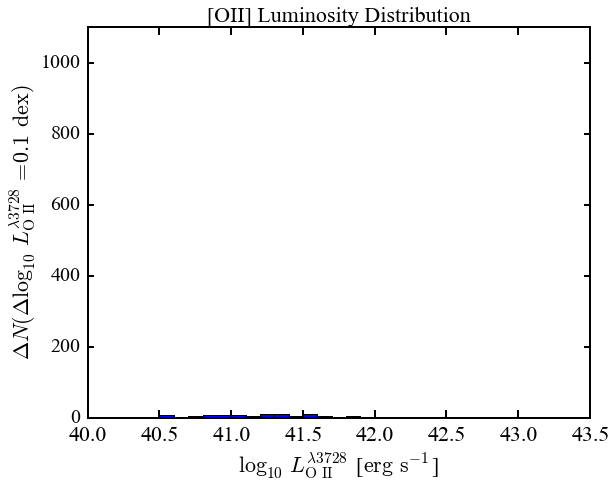

In [9]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(oii_ew[inuv], 
                           bins=np.arange(0, 200, 5), edgecolor='black')
ax.tick_params(axis='x', which='major', length=8, width=2, labelsize=22, pad=8)
ax.tick_params(axis='x', which='minor', length=4, width=2, labelsize=22, pad=8)
ax.tick_params(axis='y', which='major', length=6, width=2, labelsize=20, pad=8)
ax.tick_params(axis='y', which='minor', length=3, width=2, labelsize=20, pad=8)
this_ylim = [0, 800]
ax.set_ylim(this_ylim)
#ax.set_xscale('log')
#ax.set_xlim(3680, 3780)
ax.set_title(r'[OII] EW Distribution', fontsize=20)
ax.set_xlabel(r'$W_{\rm O\,II}^{\lambda3728}$ [$\AA$]', fontsize=20)
ax.set_ylabel(r'$\Delta N (\Delta W_{\rm O\,II}^{\lambda3728} = 5\, {\rm \AA}))$', fontsize=20)
#fig.savefig('/Users/Benjamin/Dropbox/Zhu_Projects/Fine Structure Emission/Version 1/EW_distribution.eps')

# Luminosity
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(np.log10(oiilum[inuv]), 
                           bins=np.arange(40., 43.5, 0.1), edgecolor='black')
ax.tick_params(axis='x', which='major', length=8, width=2, labelsize=22, pad=8)
ax.tick_params(axis='x', which='minor', length=4, width=2, labelsize=22, pad=8)
ax.tick_params(axis='y', which='major', length=6, width=2, labelsize=20, pad=8)
ax.tick_params(axis='y', which='minor', length=3, width=2, labelsize=20, pad=8)
    
this_ylim = [0, 1100]
ax.set_ylim(this_ylim)
#ax.set_xscale('log')
#ax.set_xlim(3680, 3780)
ax.set_title(r'[OII] Luminosity Distribution', fontsize=22)
ax.set_xlabel(r'$\log_{10}\,L_{\rm O\,II}^{\lambda3728}$ [${\rm erg\,s}^{-1}$]', fontsize=22)
ax.set_ylabel(r'$\Delta N (\Delta \log_{10}\,L_{\rm O\,II}^{\lambda3728} = 0.1\, {\rm dex})$', fontsize=22)
#fig.savefig('/Users/Benjamin/Dropbox/Zhu_Projects/Fine Structure Emission/Version 1/Lum_distribution.eps')

In [10]:
istrong = inuv[(np.nonzero(np.logical_and(oii_ew[inuv]>50., oiilum[inuv]>1.E41))[0])]
print(istrong.shape)

(40,)


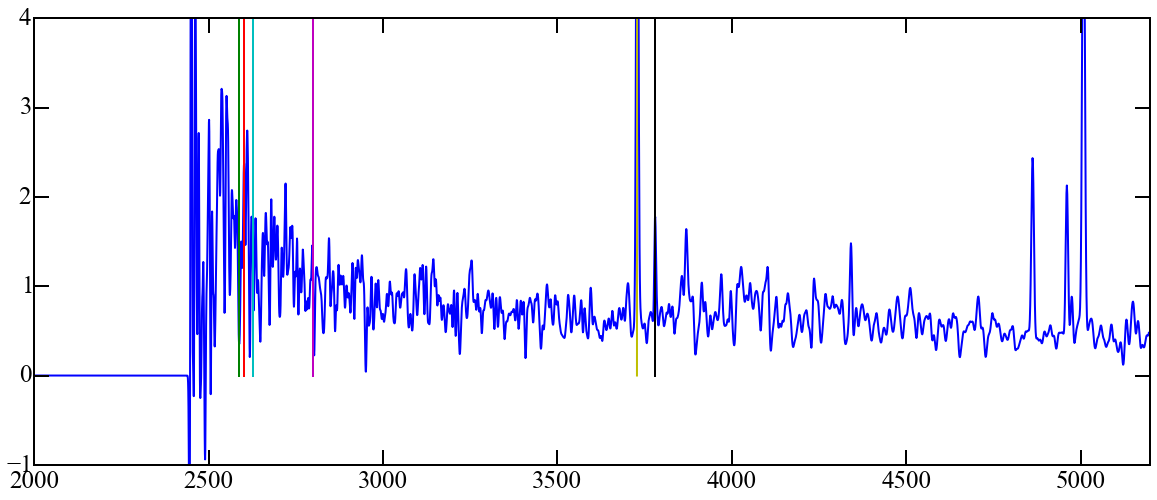

In [12]:
i=0
i = i+1
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
x = gaussian_filter1d(tmpwave, 3)
y = gaussian_filter1d(tmpflux[:,istrong[i]], 3)
ax.plot(x,y)
ax.set_xlim(2000, 5200)
ax.set_ylim(-1,4)
ax.plot([2586, 2586], [0, 5])
ax.plot([2600, 2600], [0, 5])
ax.plot([2626, 2626], [0, 5])
ax.plot([2800, 2800], [0, 5])
ax.plot([3728, 3728.5], [0, 5])
ax.plot([5577./1.475, 5577./1.475], [0, 5])

In [13]:
istrong.shape

(40,)

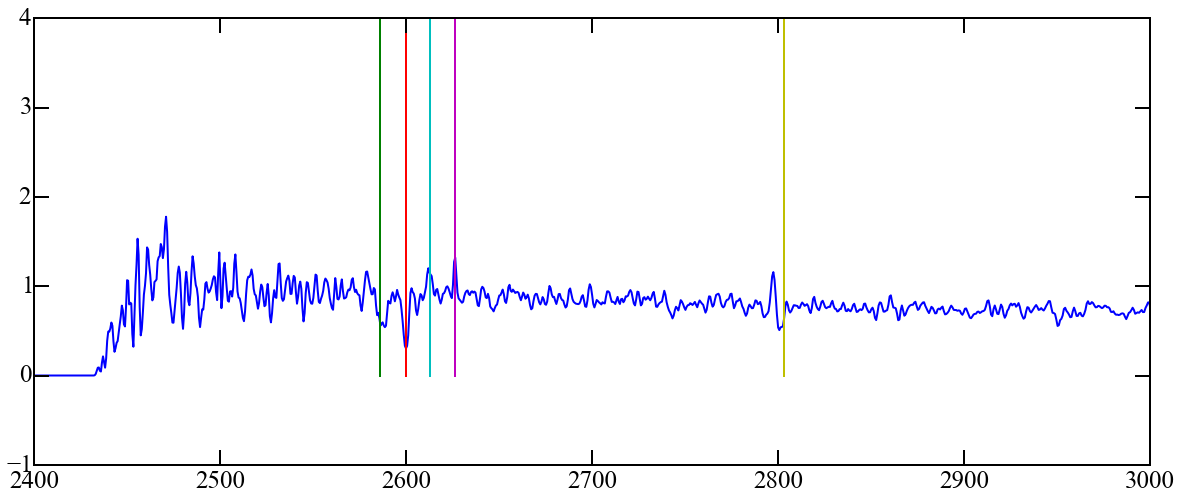

In [14]:
fullsum = np.mean(tmpflux[:, istrong], axis=1)
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
x = gaussian_filter1d(tmpwave, 1)
y = gaussian_filter1d(fullsum, 1)
ax.plot(x,y)
ax.set_xlim(2400, 3000)
ax.set_ylim(-1,4)
ax.plot([2586, 2586], [0, 5])
ax.plot([2600, 2600], [0, 5])
ax.plot([2612.65, 2612.65], [0, 5])
ax.plot([2626, 2626], [0, 5])
ax.plot([2803, 2803], [0, 5])
ax.plot([3728, 3728.5], [0, 5])

In [15]:
print(2818./2630.)
print(2773./2610.)
print(2613*1.071)
print(3730*1.058)
print(8140./1.06)

1.0714828897338402
1.0624521072796935
2798.5229999999997
3946.34
7679.245283018868


In [16]:
print(i)

1


In [17]:
print(objs_ori['PLUG_DEC'][istrong])

[ -4.3198748  -4.0618974  18.2561     19.756447   19.280708   19.473042
  19.786367   19.704497   19.715439   18.478122   19.833328   20.633017
  20.616442   21.286183   20.879819   22.445864   21.465633   22.538039
  22.519314   21.088039   20.859942   21.679197   22.612669   21.684489
  22.330972   21.793461   21.962758   22.304883   21.862958   22.300603
  21.618336   21.351994   21.296242   22.341172   52.518806   53.58374
  52.976055   52.514118   -6.2660589  -6.7720394]


In [149]:
f280n = np.genfromtxt('/Users/Benjamin/Desktop/UVIS/f280n.UVIS2.tab')
f343n = np.genfromtxt('/Users/Benjamin/Desktop/UVIS/f343n.UVIS2.tab')
f395n = np.genfromtxt('/Users/Benjamin/Desktop/UVIS/f395n.UVIS2.tab')
f390m = np.genfromtxt('/Users/Benjamin/Desktop/UVIS/f390m.UVIS2.tab')
f680n = np.genfromtxt('/Users/Benjamin/Desktop/UVIS/f680n.UVIS2.tab')
f625w = np.genfromtxt('/Users/Benjamin/Desktop/UVIS/f625w.UVIS2.tab')
f621m = np.genfromtxt('/Users/Benjamin/Desktop/UVIS/f621m.UVIS2.tab')

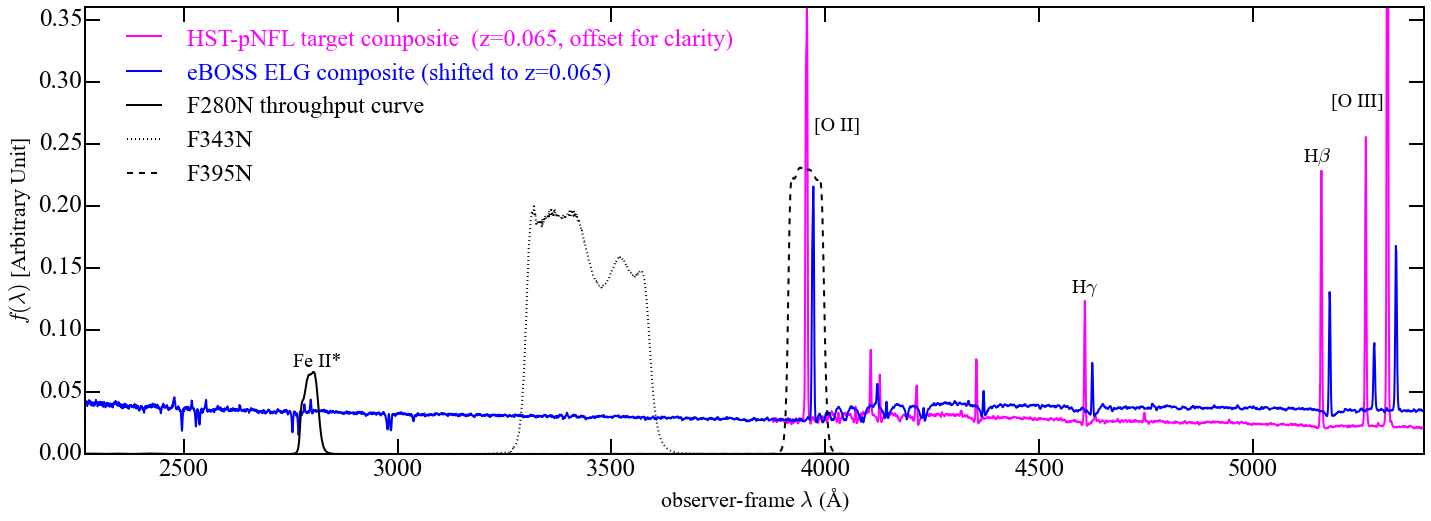

In [178]:
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(111)
i3650 = np.searchsorted(nfl_sdss['WAVE'][0], 3650.)
ax.plot(nfl_sdss['WAVE'][0][i3650:]*(1.+0.061), nfl_composite[i3650:]*0.0008, color='magenta')
ax.plot(elg_composite[0]['WAVE']*(1.+0.065), elg_composite[0]['FLUXMEDIAN']/10, 'b')
ax.plot(f280n[:,1], f280n[:,2], '-k')
ax.plot(f343n[:,1], f343n[:,2], ':k')
ax.plot(f395n[:,1], f395n[:,2]*1.05, '--k')
#ax.plot(f621m[:,1], f621m[:,2]*1.05, '-.k')
#p680n, = ax.plot(f680n[:,1], f680n[:,2]*1.05, '-k')
#p680n.set_dashes([8, 4, 2, 4, 2, 4])
#leg = ax.legend(['HST-pNFL target composite  (z=0.065, offset for clarity)', 'eBOSS ELG composite (shifted to z=0.065)', \
#                 'F280N throughput curve', 'F343N', 'F395N', 'F621M', 'F680N'], \
leg = ax.legend(['HST-pNFL target composite  (z=0.065, offset for clarity)', 'eBOSS ELG composite (shifted to z=0.065)', \
                 'F280N throughput curve', 'F343N', 'F395N'], \
                bbox_to_anchor=(0.01, 0.90, 1., .102), loc=2, frameon=False, fontsize=24, )
color_legend_texts(leg)
ax.set_xlim(2270, 5400)
#ax.set_xlim(2100, 3200)
ax.set_ylim(0.0004,0.36)
#ax.plot([2773, 2773], [0, 0.07], 'g')
#ax.plot([2818, 2818], [0, 0.07], 'g')
ax.set_xlabel(r'observer-frame $\lambda$ ($\AA$)', fontsize=22)
ax.set_ylabel(r'$f(\lambda)$ [Arbitrary Unit]', fontsize=22)

#ax.text(6563.*(1.+0.065)+10, 0.30, r'H$\alpha$', fontsize=20)
ax.text(5007.*(1.+0.065)-150, 0.28, r'[O III]', fontsize=20)
ax.text(4861.*(1.+0.065)-60, 0.235, r'H$\beta$', fontsize=20)
ax.text(4341.*(1.+0.065)-50, 0.13, r'H$\gamma$', fontsize=20)
#ax.text(3889.*(1.+0.065)-100, 0.09, r'[Ne III]', fontsize=20)
ax.text(3730.*(1.+0.065)+2, 0.26, r'[O II]', fontsize=20)
ax.text(2626.*(1.+0.065)-40, 0.07, r'Fe II*', fontsize=20)
fig.savefig('/Users/Benjamin/Desktop/UVIS/composite_filters.eps')

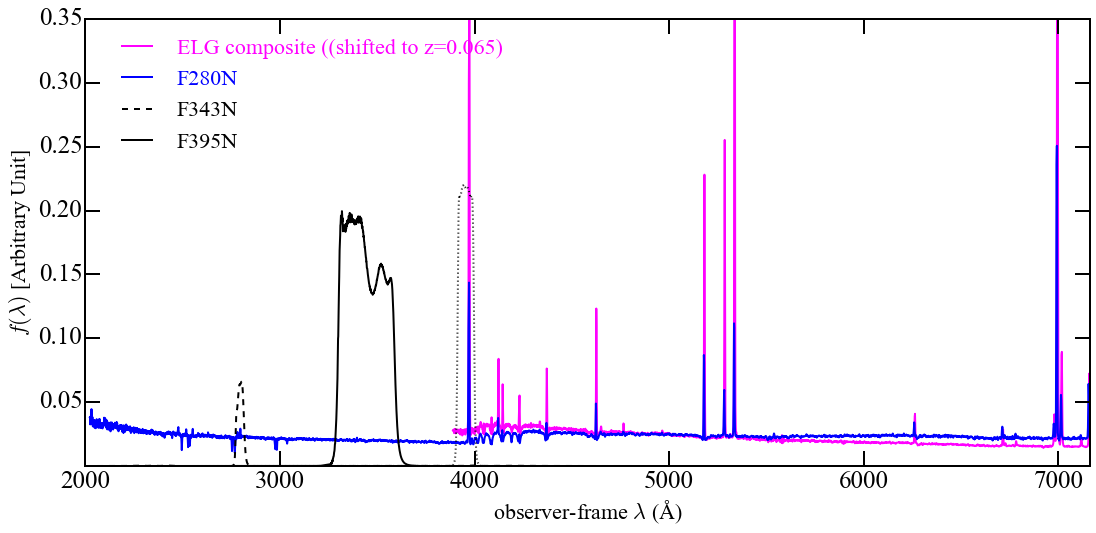

In [141]:

fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
i3650 = np.searchsorted(nfl_sdss['WAVE'][0], 3650.)
ax.plot(nfl_sdss['WAVE'][0][i3650:]*(1.+0.0655), nfl_composite[i3650:]*0.0008, color='magenta')
ax.plot(elg_composite[0]['WAVE']*(1.+0.065), elg_composite[0]['FLUXMEDIAN']/15, 'b')
ax.plot(f280n[:,1], f280n[:,2], '--k')
ax.plot(f343n[:,1], f343n[:,2], '-k')
ax.plot(f395n[:,1], f395n[:,2], ':k')
leg = ax.legend(['ELG composite ((shifted to z=0.065)', 'F280N', 'F343N', 'F395N'], bbox_to_anchor=(0.01, 0.90, 1., .102), loc=2, frameon=False, fontsize=22)
color_legend_texts(leg)
ax.set_xlim(2000, 7160)
ax.set_ylim(0.0004,0.35)
#ax.plot([2773, 2773], [0, 0.07], 'g')
#ax.plot([2818, 2818], [0, 0.07], 'g')
ax.set_xlabel(r'observer-frame $\lambda$ ($\AA$)', fontsize=22)
ax.set_ylabel(r'$f(\lambda)$ [Arbitrary Unit]', fontsize=22)

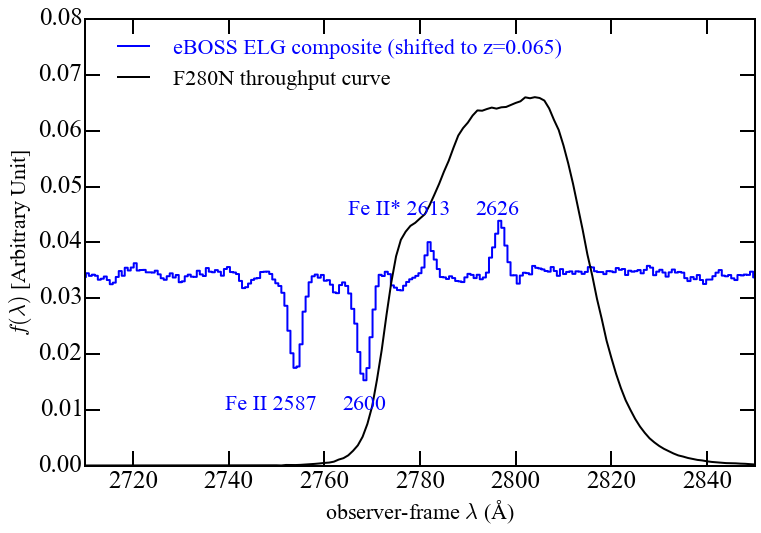

In [120]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(elg_composite[0]['WAVE']*(1.+0.065), elg_composite[0]['FLUXMEDIAN']/10, drawstyle='steps')
ax.plot(f280n[:,1], f280n[:,2], '-k')
#ax.plot(f395n[:,1], f395n[:,2], 'k')
leg = ax.legend(['eBOSS ELG composite (shifted to z=0.065)', 'F280N throughput curve'], \
                                bbox_to_anchor=(0.01, 0.90, 1., .102), loc=2, frameon=False, fontsize=22, )
color_legend_texts(leg)
ax.set_xlim(2710, 2850)
ax.set_ylim(0,0.08)
#ax.plot([2773, 2773], [0, 0.07], 'g')
#ax.plot([2818, 2818], [0, 0.07], 'g')
ax.set_xlabel(r'observer-frame $\lambda$ ($\AA$)', fontsize=22)
ax.set_ylabel(r'$f(\lambda)$ [Arbitrary Unit]', fontsize=22)
ax.text(2613.*(1.+0.065)-18, 0.045, r'Fe II* 2613', color='blue', fontsize=22)
ax.text(2626.*(1.+0.065)-5, 0.045, r'2626', color='blue', fontsize=22)
ax.text(2587.*(1.+0.065)-16, 0.010, r'Fe II 2587', color='blue', fontsize=22)
ax.text(2600.*(1.+0.065)-5, 0.010, r'2600', color='blue', fontsize=22)
fig.savefig('/Users/Benjamin/Desktop/UVIS/composite_filters_f280n.eps')

(0, 0.27)

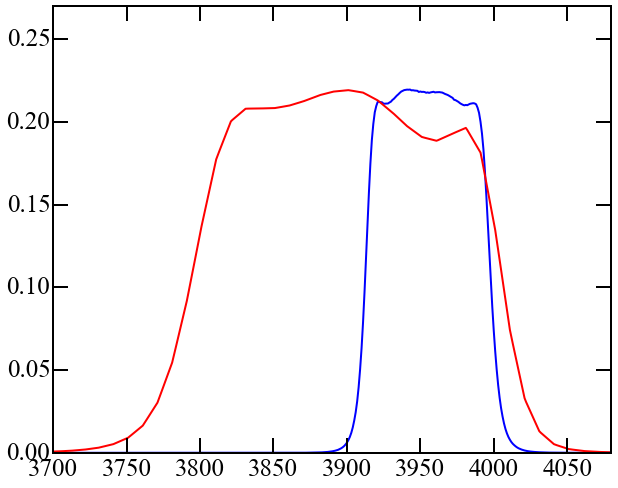

In [181]:
plt.plot(f395n[:,1], f395n[:,2], 'b')
plt.plot(f390m[:,1], f390m[:,2], 'r')
plt.xlim(3700, 4080)
plt.ylim(0,0.27)
#plt.plot([2773, 2773], [0, 0.07], 'g')
#plt.plot([2818, 2818], [0, 0.07], 'g')

In [66]:
iz = np.nonzero(np.logical_and(np.logical_and(np.logical_and(np.logical_and(np.logical_and(np.logical_and(
                    dr7_info['Z']>0.064, dr7_info['Z']<0.066), 
                    dr7_mass['MEDIAN']>7.), dr7_mass['MEDIAN']<12.), 
                    dr7_ssfr['MEDIAN']<-1), dr7_ssfr['MEDIAN']>-20),
                    dr7_info['SN_MEDIAN']>0.))[0]
print(iz.shape)

(10240,)


844


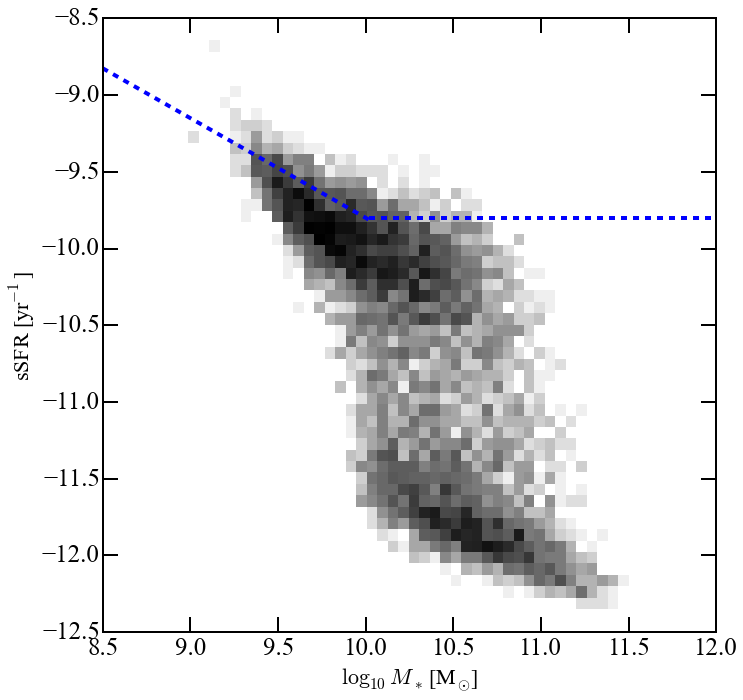

In [95]:
fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(111)
ax.hist2d(dr7_mass['MEDIAN'][iz], dr7_ssfr['MEDIAN'][iz], bins=80, cmin=2, cmap='Greys', norm=LogNorm())
#ax.plot(dr7_mass['MEDIAN'][iz], dr7_ssfr['MEDIAN'][iz], '.')
#ax.plot(dr7_mass[1000:11000]['MEDIAN'], dr7_sfr[1000:11000]['MEDIAN'], '.')
#ax.plot(mass[iarchetype], sfr[iarchetype]-mass[iarchetype], '*', ms=15)
ax.set_ylim(-12.5, -8.5)
ax.set_xlim(8.5, 12.)
ax.set_xlabel(r'$\log_{10}$ $M_*$ [M$_\odot$]', fontsize=22)
ax.set_ylabel(r'sSFR [yr$^{-1}$]', fontsize=22)
xmass = np.linspace(8.5, 12.0, num=100)
yssfr = -0.65*(xmass-10.)-9.8
ilow = np.searchsorted(xmass, 9.0)
isort = xmass.size - np.searchsorted(yssfr[::-1], -9.8)
iselect = np.nonzero(np.logical_and(dr7_ssfr['MEDIAN'][iz]>-9.8, dr7_ssfr['MEDIAN'][iz]>-0.65*(dr7_mass['MEDIAN'][iz]-10.)-9.8))[0]
print(iselect.size)
ax.plot(xmass[:isort+1], yssfr[:isort+1], '--b', lw=4)
ax.plot(xmass[isort:], xmass[isort:]/xmass[isort:]*(-9.80), '--b', lw=4)
#ax.plot([9.0, 9.0], [yssfr[ilow], -8.5], '--b', lw=3)
#print(iarchetype.size)

177
112
46
  10425 178.950943 -0.548661
  10931 178.950943 -0.548661
  23846 214.843231 -0.080412
  24317 214.843231 -0.080412
 113800 169.752884 68.033020
 155733 215.384262 3.239949
 168857 225.886475 61.289570
 185016 351.637756 -10.503380
 294032 155.610886 53.296211
 319005 204.200027 59.064163
 333827 324.627686 0.683894
 337330 155.484619 5.613559
 362736 221.510727 50.077003
 367224 248.734726 32.998070
 388825 127.758049 4.055246
 398157 127.377419 31.163918
 400641 140.534836 38.131268
 404196 168.902740 9.839472
 436111 179.446442 58.584145
 461645 179.236435 44.832783
 462137 182.560287 44.665779
 462820 186.585510 45.622383
 485914 151.452576 37.749313
 486209 154.635056 38.168709
 498887 186.071823 42.472801
 501136 192.090317 47.010868
 529402 244.636063 27.731224
 581231 196.305161 12.788695
 585419 213.581482 10.403776
 601872 143.569946 10.677863
 607034 165.841064 13.806926
 660315 121.050789 52.778694
 690439 191.202042 33.909134
 725005 200.003235 30.821304
 810038

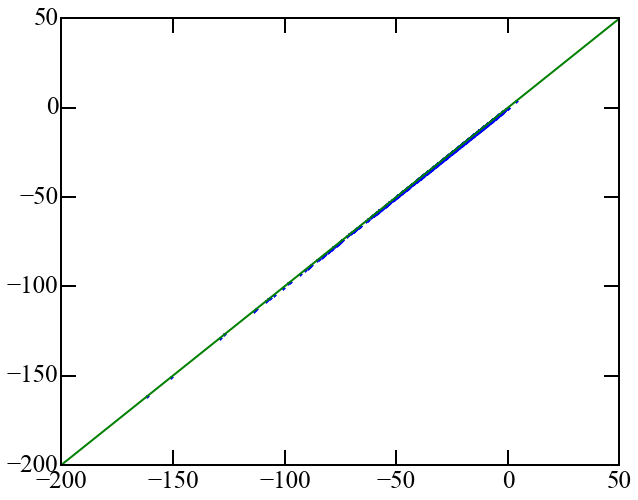

In [223]:
ioii = np.nonzero((dr7_line['OII_3729_REQW'][iz[iselect]]+dr7_line['OII_3726_REQW'][iz[iselect]])<-80.)[0]
icont = np.nonzero((dr7_line['OII_3729_FLUX'][iz[iselect]]/dr7_line['OII_3729_CONT'][iz[iselect]] \
                   +dr7_line['OII_3726_FLUX'][iz[iselect]]/dr7_line['OII_3726_CONT'][iz[iselect]])>50.)[0]
igalex = np.nonzero(np.logical_and(dr7_galex['NUV_MAG'][iz[iselect[ioii]]]<19.2, dr7_galex['NUV_MAG'][iz[iselect[ioii]]]>15.))[0]
print(ioii.size)
print(icont.size)
print(igalex.size)
plt.plot(dr7_line['OII_3729_REQW'][iz[[iselect]]], dr7_line['OII_3726_REQW'][iz[iselect]], '.')
plt.plot([-200, 50], [-200, 50])
for i in np.arange(igalex.size):
    print("{0:7d}".format(iz[iselect[ioii[igalex]]][i]),\
          "{0:.6f}".format(dr7_info['RA'][iz[iselect[ioii[igalex]]]][i]), \
          "{0:.6f}".format(dr7_info['DEC'][iz[iselect[ioii[igalex]]]][i]))

(0, 80)

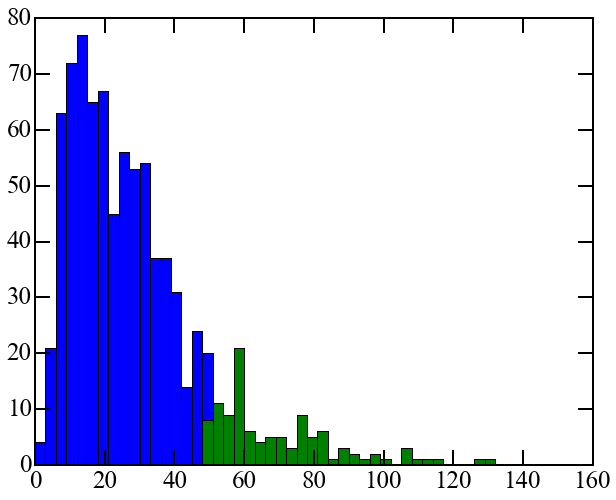

In [123]:
x = plt.hist(-dr7_line['OII_3729_EQW'][iz[iselect]], bins=50, range=(0, 150))#, normed=True)
y = plt.hist(-dr7_line['OII_3729_EQW'][iz[iselect[ioii]]], bins=50, range=(0,150))#, normed=True)
plt.ylim(0,80)
#print(dr7_galex['FUV_MAG_APER_2'][iz][iselect])

In [271]:
lf_z = np.linspace(0.1, 2.5, num=40)
lf_oii = np.power(10, np.linspace(39, 44, num=40))
#lf_L = np.power(10, 0.341*lf_z + 40.773)
lf_L = np.power(10, 0.30*lf_z + 40.773)
#lf_logphi = 0.475*lf_z - 2.522
lf_logphi = 0.40*lf_z - 2.522
lf_alpha = 0.25*lf_z - 1.6 + 1.
#lf_alpha = 0*lf_z - 1.257+1.
lf_lf = np.zeros((40, 40))
lf_sigma = -0.0*(lf_z-1.) + 0.46
for i in np.arange(40):
    lf_lf[:,i] = np.power(10, lf_logphi)*np.power(lf_oii[i]/lf_L, lf_alpha)\
        *np.exp(-np.power(np.log10(1.+lf_oii[i]/lf_L)/np.sqrt(2.)/lf_sigma, 2))

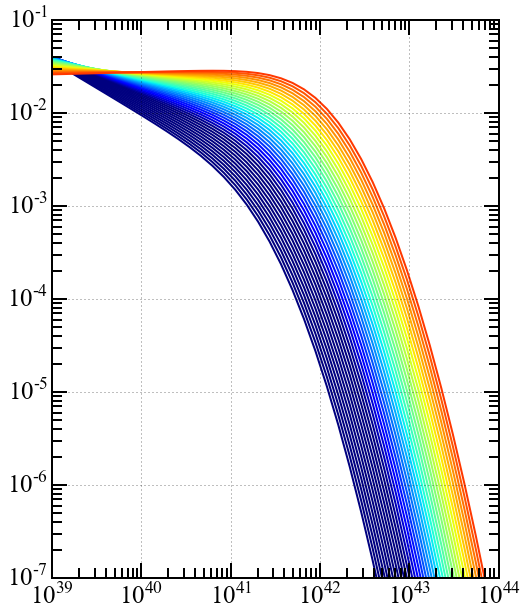

In [278]:
CM = plt.get_cmap('jet_r')

fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111)
for i in np.arange(40):
    color = np.fmin(np.fmax((2.8-lf_z[i])/2, 0), 1.)
    thiscolor = CM(color)
    ax.loglog(lf_oii, lf_lf[i,:], color=thiscolor)
ax.set_ylim(1E-7, 1E-1)
ax.grid()
#plt.colorbar()

In [270]:
lf_alpha-1.

array([-1.575     , -1.55961538, -1.54423077, -1.52884615, -1.51346154,
       -1.49807692, -1.48269231, -1.46730769, -1.45192308, -1.43653846,
       -1.42115385, -1.40576923, -1.39038462, -1.375     , -1.35961538,
       -1.34423077, -1.32884615, -1.31346154, -1.29807692, -1.28269231,
       -1.26730769, -1.25192308, -1.23653846, -1.22115385, -1.20576923,
       -1.19038462, -1.175     , -1.15961538, -1.14423077, -1.12884615,
       -1.11346154, -1.09807692, -1.08269231, -1.06730769, -1.05192308,
       -1.03653846, -1.02115385, -1.00576923, -0.99038462, -0.975     ])

In [83]:
dr7_info = fitsio.read('/Users/Benjamin/AstroData/Garching/gal_info_dr7_v5_2.fit.gz', ext=1)
dr7_sfr = fitsio.read('/Users/Benjamin/AstroData/Garching/gal_totsfr_dr7_v5_2.fits.gz', ext=1)
dr7_ssfr = fitsio.read('/Users/Benjamin/AstroData/Garching/gal_totspecsfr_dr7_v5_2.fits.gz', ext=1)
dr7_mass = fitsio.read('/Users/Benjamin/AstroData/Garching/totlgm_dr7_v5_2.fit.gz', ext=1)
dr7_phi = fitsio.read('/Users/Benjamin/AstroData/Garching/gal_phi_dr7_v5_2.fits', ext=1)
dr7_uniq = fitsio.read('/Users/Benjamin/AstroData/Garching/gal_uniq_dr7_v5_2.fits', ext=1)
dr7_line = fitsio.read('/Users/Benjamin/AstroData/Garching/gal_line_dr7_v5_2.fit.gz', ext=1)

In [84]:
dr7_galex = fitsio.read('/Users/Benjamin/AstroData/Garching/gal_galex_dr7_v5_2.fits', ext=1)
dr7_fibersfr = fitsio.read('/Users/Benjamin/AstroData/Garching/gal_fibsfr_dr7_v5_2.fits.gz', ext=1)

In [96]:
print('RA,     DEC,    MASS,   SFR,  fiber SFR, sSFR,  R_EXP, SFR/A, fiber SFR/A,  u, u fiber, nuv, nuv fiber')
for i, j in zip(nfl_sdss['INDEX'][0][index_of_index], np.arange(4)):
    sfrarea = np.power(10, dr7_sfr['MEDIAN'][i])/np.pi/(dr7_phi['R_EXP'][i][0]*1.256)**2
    fibersfrarea = np.power(10, dr7_fibersfr['MEDIAN'][i])/np.pi/(1.5*1.256)**2
    fiber_nuv = dr7_info['PLUG_MAG'][i][0] - data_skyserver[j][4] + dr7_galex['NUV_MAG'][i]
    fiber_fuv = dr7_info['PLUG_MAG'][i][0] - data_skyserver[j][4] + dr7_galex['FUV_MAG'][i]
    print("{0:.3f} {1:6.3f}  {2:.3f}  {3:6.3f}  {4:6.3f}  {5:6.3f}  {6:6.3f}  {7:6.3f}    {8:6.3f}   {9:6.3f} {10:6.3f} {11:6.3f} {12:6.3f} {13:6.3f} {14:6.3f}".format(dr7_info['RA'][i], dr7_info['DEC'][i], \
          dr7_mass['MEDIAN'][i], np.power(10, dr7_sfr['MEDIAN'][i]), np.power(10, dr7_fibersfr['MEDIAN'][i]), dr7_ssfr['MEDIAN'][i], dr7_phi['R_EXP'][i][0], \
          sfrarea , fibersfrarea, data_skyserver[j][4], dr7_info['PLUG_MAG'][i][0], dr7_galex['NUV_MAG'][i], fiber_nuv, dr7_galex['FUV_MAG'][i], fiber_fuv))
print(dr7_line['OII_3726_EQW'][nfl_sdss['INDEX'][0]])

RA,     DEC,    MASS,   SFR,  fiber SFR, sSFR,  R_EXP, SFR/A, fiber SFR/A,  u, u fiber, nuv, nuv fiber
179.446 58.584  9.421   4.766   1.492  -8.816   2.323   0.178     0.134   17.722 18.692 18.306 19.277 18.638 19.608
244.636 27.731  9.280  15.679  13.077  -8.143   3.056   0.339     1.173   17.751 18.046 17.691 17.986 18.120 18.415
182.560 44.666  9.880  12.266  10.629  -8.798   1.347   1.364     0.953   18.486 18.622 18.140 18.277 18.589 18.726
127.758  4.055  9.756  10.134   7.275  -8.778   2.523   0.321     0.652   17.532 18.454 17.827 18.748 18.431 19.353
[-63.53063583 -76.31105042 -55.51638794 -42.38479996 -61.41056061
 -75.7973175  -55.92394257 -61.03907013]


In [184]:
print('INDEX, ra, ra fiber,    u   u totaa')
for i, j in zip(nfl_sdss['INDEX'][0], np.arange(8)):
    #print("{0:6d}  {1:.6f}  {2:.6f}  {3:.6f}  {4:.6f}".format(i, dr7_info['RA'][i][0], data_skyserver[j][2], dr7_info['PLUG_MAG'][i][0], data_skyserver[j][4]))
    fiber_nuv = dr7_info['PLUG_MAG'][i][0] - data_skyserver[j][4] + dr7_galex['NUV_MAG'][i]
    print("{0:6d}  {1:.6f}  {2:.6f}  {3:.6f}  {4:.6f}  {5:.6f}".format(i, data_skyserver[j][2], dr7_info['PLUG_MAG'][i][0], data_skyserver[j][4], dr7_galex['NUV_MAG'][i], fiber_nuv))

INDEX, ra, ra fiber,    u   u totaa
436111  179.446451  18.692499  17.722150  18.306219  19.276568
388825  127.758047  18.454000  17.751260  17.826565  18.529305
601872  143.569934  20.357599  18.486000  18.948124  20.819723
461645  179.236432  19.093700  17.532270  17.668858  19.230288
462137  182.560285  18.622499  17.767190  18.140104  18.995414
529402  244.636076  18.046000  17.065990  17.690878  18.670887
826851  161.513414  19.159500  17.707580  18.509342  19.961262
866734  187.590171  20.332001  18.275890  18.189762  20.245873


In [ ]:
179.446451060553,58.5841325235255,17.72215,16.95618,16.86512,16.59029,16.59573,0.064461
127.758047177716,4.05524750834444,17.75126,16.96656,16.74418,16.31073,16.35811,0.06475648
143.569934270161,10.6778559344543,18.486,17.60747,17.35559,17.08135,17.07806,0.06525452
179.236432162099,44.8327830805518,17.53227,16.96531,16.93552,16.76346,16.78894,0.06439935
182.560285457813,44.6657831628324,17.76719,16.99928,16.86522,16.50574,16.61898,0.06594051
244.636075514965,27.7312286348228,17.06599,16.52032,16.73591,16.24394,16.43703,0.06422318
161.513414086334,15.4185175577052,17.70758,16.86378,16.67677,16.3776,16.3641,0.06442506
187.590171299233,17.7381113893822,18.27589,17.39026,17.20262,17.01104,17.03539,0.06586163


In [86]:
data_skyserver = np.genfromtxt('/Users/Benjamin/Desktop/UVIS/notebook.csv',delimiter=",",skip_header=1)

In [173]:
data_skyserver[0][4]

17.722149999999999

In [349]:
itmp = np.nonzero(np.logical_and(np.logical_and(np.logical_and(np.logical_and(np.logical_and(np.logical_and(
                    dr7_info['Z']>0.02, dr7_info['Z']<0.30), 
                    dr7_mass['MEDIAN']>7.), dr7_mass['MEDIAN']<13.), 
                    dr7_ssfr['MEDIAN']<-1), dr7_ssfr['MEDIAN']>-20),
                    dr7_info['SN_MEDIAN']>3.))[0]
iarche = np.random.choice(itmp, 10000)
print(iarche.shape)

(10000,)


In [350]:
objs_dtype = [('PLATE', 'i4'),
              ('MJD', 'i4'),
              ('FIBER', 'i4'),
              ('RA', 'f8'),
              ('DEC', 'f8'),
              ('Z', 'f8'),
              ('MASS', 'f8'), 
              ('SFR', 'f8')]
objs = np.zeros(iarche.size, dtype=objs_dtype)
objs['PLATE'] = dr7_info['PLATEID'][iarche]
objs['MJD'] = dr7_info['MJD'][iarche]
objs['FIBER'] = dr7_info['FIBERID'][iarche]
objs['RA'] = dr7_info['RA'][iarche]
objs['DEC'] = dr7_info['DEC'][iarche]
objs['Z'] = dr7_info['Z'][iarche]
objs['MASS'] = dr7_mass['MEDIAN'][iarche]
objs['SFR'] = dr7_sfr['MEDIAN'][iarche]

In [351]:
fits = fitsio.FITS('/Users/Benjamin/AstroData/Garching/Archetype_sample.fits', 'rw', clobber=True)
fits.write(objs)
fits.close()

In [352]:
test = fitsio.read('/Users/Benjamin/AstroData/Garching/Archetype_sample.fits')

dtype([('PLATEID', '>i2'), ('MJD', '>i4'), ('FIBERID', '>i2'), ('PHOTOID', '>i2', (5,)), ('RA', '>f4'), ('DEC', '>f4'), ('PLUG_MAG', '>f4', (5,)), ('PRIMTARGET', '>i2'), ('SECTARGET', '>i2'), ('TARGETTYPE', 'S19'), ('SPECTROTYPE', 'S6'), ('SUBCLASS', 'S21'), ('Z', '>f4'), ('Z_ERR', '>f4'), ('Z_WARNING', '>i2'), ('V_DISP', '>f4'), ('V_DISP_ERR', '>f4'), ('SN_MEDIAN', '>f4'), ('E_BV_SFD', '>f4'), ('ZTWEAK', '>f4'), ('ZTWEAK_ERR', '>f4'), ('SPECTRO_MAG', '>f4', (3,)), ('KCOR_MAG', '>f4', (3,)), ('KCOR_MODEL_MAG', '>f4', (5,)), ('RELEASE', 'S12')])

In [354]:
archespec.rest_allspec(overwrite=True)

Now I am writing everything out...


In [326]:
reload(datapath)

<module 'datapath' from '/Users/Benjamin/Code/BGT-Cosmology/Spectroscopy/archetype/datapath.py'>

In [327]:
datapath.garching_path()

'/Users/Benjamin/AstroData/Garching'

In [356]:
elg_composite.dtype

dtype([('WAVE', '>f4', (7382,)), ('FLUXMEDIAN', '>f4', (7382,))])

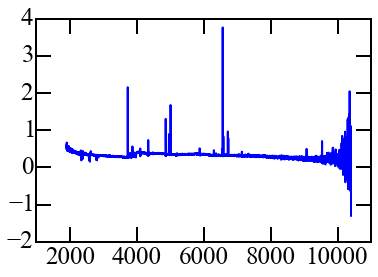

In [367]:
plt.plot(elg_composite[0]['WAVE'], elg_composite[0]['FLUXMEDIAN'])

In [129]:
ioii.size

112

(0, 50)

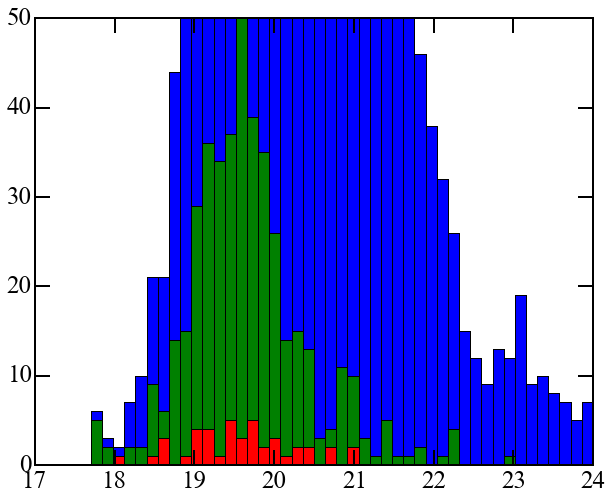

In [131]:
xx = plt.hist(dr7_galex['FUV_MAG'][iz], bins=50, range=(17,24))
yy = plt.hist(dr7_galex['FUV_MAG'][iz[iselect]], bins=50, range=(17,24))
zz = plt.hist(dr7_galex['FUV_MAG'][iz[iselect[ioii]]], bins=50, range=(17,24))
plt.ylim(0,50)

200000.0 2222.222222222222


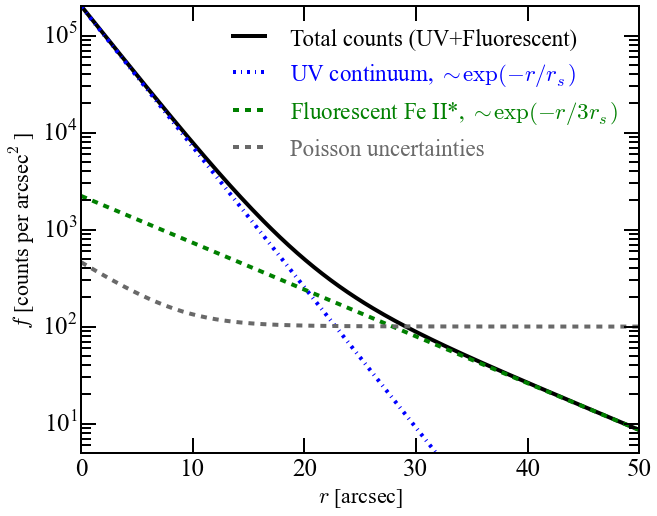

In [244]:
r = np.linspace(0, 50, num=200)
r_uv = 3.
f0_uv = 200000.
f0_sky = 10000. #2700./100. #f0_uv/1000.
f_uv = f0_uv*np.exp(-r/r_uv)

r_fe = r_uv*3.
f0_fe = f0_uv*r_uv**2/10./r_fe**2
f_fe = f0_fe*np.exp(-r/r_fe)

#mu0_uv = 20.
#mu_uv = mu0_uv + 2.5/np.log(10.)*r/r_uv
#mu0_feii = 

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.semilogy(r, f_uv+f_fe, 'k', lw=4)
ax.semilogy(r, f_uv, 'b-.', lw=4)
ax.semilogy(r, f_fe, 'g--', lw=4)
#ax.semilogy(np.r_[[0],r[10:]], np.r_[f_fe_iso[10], f_fe_iso[10:]], '-.', color='orange', lw=4)
#ax.semilogy(np.r_[r[10],r[10:]], np.r_[[1E-10], f_fe_iso[10:]], '-.', color='orange', lw=4)
ax.semilogy(r, np.sqrt(f_uv+f_fe+f0_sky), '--', color='dimgrey', lw=4)
leg = ax.legend(['Total counts (UV+Fluorescent)', 'UV continuum, $\sim \exp(-r/r_s)$', \
                 'Fluorescent Fe II*, $\sim \exp(-r/3r_s)$', 'Poisson uncertainties'], \
                 loc=1, frameon=False, fontsize=23)
#                bbox_to_anchor=(0.91, 0.90, 1., .102), loc=2, frameon=False, fontsize=20)
color_legend_texts(leg)
ax.set_ylim(5E-0, 2E5)
ax.set_xlabel('$r$ [arcsec]', fontsize=22)
ax.set_ylabel(r"$f$ [counts per arcsec$^2$]", fontsize=22)

print(f0_uv, f0_fe)
fig.savefig('/Users/Benjamin/Desktop/UVIS/exponential_profile.eps')

200000.0 2222.222222222222


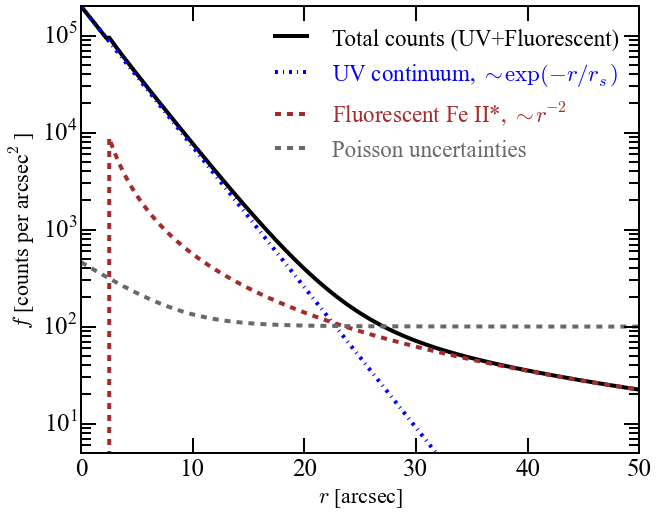

In [243]:
r = np.linspace(0, 50, num=200)
r_uv = 3.
f0_uv = 200000.
f0_sky = 10000. #2700./100. #f0_uv/1000.
f_uv = f0_uv*np.exp(-r/r_uv)

r_fe = 9.
f0_fe = f0_uv*r_uv**2/10./r_fe**2
f_fe = f0_fe*np.exp(-r/r_fe)

r_fe_iso = r_uv*3.
f0_fe_iso = f0_uv*r_uv**2/20./(np.log(15./r_uv))
f_fe_iso = f0_fe_iso*(1./r)**2

#mu0_uv = 20.
#mu_uv = mu0_uv + 2.5/np.log(10.)*r/r_uv
#mu0_feii = 

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.semilogy(r, np.r_[f_uv[:10],f_uv[10:]+f_fe_iso[10:]], 'k', lw=4)
ax.semilogy(r, f_uv, 'b-.', lw=4)
ax.semilogy(np.r_[r[10],r[10:]], np.r_[[1E-10], f_fe_iso[10:]], '--', color='brown', lw=4)
ax.semilogy(r, np.sqrt(f_uv+f_fe+f0_sky), '--', color='dimgrey', lw=4)
leg = ax.legend(['Total counts (UV+Fluorescent)', 'UV continuum, $\sim \exp(-r/r_s)$', \
                 r'Fluorescent Fe II*, $\sim r^{-2}$', 'Poisson uncertainties'], \
                 loc=1, frameon=False, fontsize=23)
#                bbox_to_anchor=(0.91, 0.90, 1., .102), loc=2, frameon=False, fontsize=20)
color_legend_texts(leg)

ax.set_ylim(5E-0, 2E5)
ax.set_xlabel('$r$ [arcsec]', fontsize=22)
ax.set_ylabel(r"$f$ [counts per arcsec$^2$]", fontsize=22)

print(f0_uv, f0_fe)
fig.savefig('/Users/Benjamin/Desktop/UVIS/powerlaw_profile.eps')

In [215]:
18.8+2.5*np.log10(1./0.8)#-2.5*np.log10(1.25*1.25/(3.75*3.75))#-2.5*np.log10(2.)

19.042275032520141

In [201]:
np.r_[[0], [1, 2]]

array([0, 1, 2])

In [80]:
19.04+2.5*np.log10(2*2*np.pi)#-2.5*np.log10(2.)

21.788024660055239

In [229]:
nfl_sdss['ALLFLUX'].shape

(1, 13659, 8)

In [86]:
15367./np.sqrt(15367.+2715.)

114.27884932551329

In [128]:
(1.-np.exp(-15./2.))

0.99944691562985222

In [28]:
np.sqrt(1./3.14)

0.56433264798310034

In [34]:
0.6*0.6*3.14

1.1304

In [33]:
0.56*0.56*3.14

0.9847040000000001

In [126]:
imin = np.argmin(np.abs(dr7_info['RA']-127.75746))
print(dr7_info['Z'][imin])
print(dr7_info['RA'][imin])
print(dr7_info['DEC'][imin])
print(dr7_mass['MEDIAN'][imin])
print(np.power(10, dr7_sfr['MEDIAN'][imin]))
print(dr7_ssfr['MEDIAN'][imin])
print(np.power(10, dr7_fibersfr['MEDIAN'][imin]))
print(np.power(10., dr7_sfr['MEDIAN'][imin])/np.pi/(dr7_phi['R_EXP'][imin][0]*1.256)**2)
print(np.power(10., dr7_fibersfr['MEDIAN'][imin])/np.pi/(1.5*1.256)**2)
print(dr7_galex['NUV_MAG'][imin])
print(dr7_line['OII_3729_FLUX'][imin]/dr7_line['OII_3729_CONT'][imin]+dr7_line['OII_3726_FLUX'][imin]/dr7_line['OII_3726_CONT'][imin])

0.0650508
127.757
4.05415
9.8806
7.82132919995
-9.02692
7.34821896085
0.0763304432555
0.658977246395
0.0
58.7676


In [113]:
17.827+2.5*np.log10(5./3.) + (18.454-17.751)

19.084621874040891

In [117]:
print(dr7_info['Z'][nfl_sdss['INDEX']][0][index_of_index])

[ 0.064461    0.06422318  0.06594051  0.06475648]


In [123]:
xx = dr7_line['OII_3729_FLUX'][nfl_sdss['INDEX'][0]]/dr7_line['OII_3729_CONT'][nfl_sdss['INDEX'][0]] \
                   +dr7_line['OII_3726_FLUX'][nfl_sdss['INDEX'][0]]/dr7_line['OII_3726_CONT'][nfl_sdss['INDEX'][0]]
xx[index_of_index]

array([ 61.84864044,  73.18855286,  60.36682129,  74.24503326], dtype=float32)

In [130]:
0.564*0.564*np.pi

0.9993280567362987

In [137]:
a = fitsio.read('/Users/Benjamin/Desktop/UVIS/h2templat_J3.fits', ext=0)

In [165]:
np.exp(10./2.)/np.exp(2./2)

54.598150033144243

In [231]:
7500./36./60.

3.4722222222222223